<a href="https://colab.research.google.com/github/millermuttu/Notebooks/blob/master/cattle_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *

In [0]:
folder = 'brahman'
file = 'brahman.csv'

In [0]:
folder = 'hereford'
file = 'hereford.csv'


In [0]:
folder = 'holstein'
file = 'holstein.csv'


In [0]:
path = Path('./drive/My Drive/cattle models')


In [0]:
path = Path('data/cattle')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [7]:
path

PosixPath('data/bears')

In [0]:
classes = ['hereford','holstein','brahman']

In [0]:
download_images(file, dest, max_pics=100)

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [15]:
data.classes

['brahman', 'hereford', 'holstein']

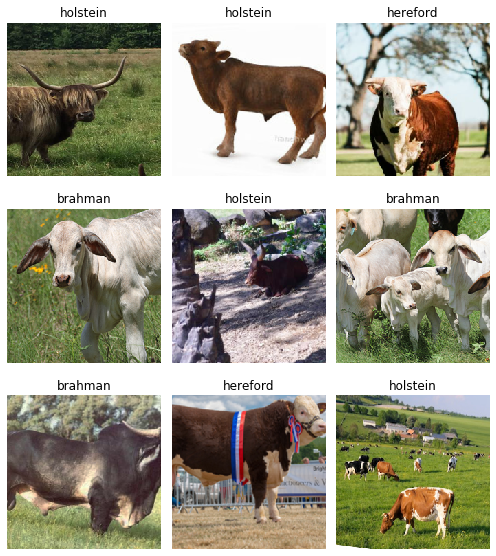

In [16]:
data.show_batch(rows=3, figsize=(7,8))

In [17]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['brahman', 'hereford', 'holstein'], 3, 221, 55)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.877811,2.136144,0.636364,00:07
1,1.586326,1.027877,0.400000,00:04
2,1.287817,1.117555,0.345455,00:04
3,1.134406,1.132571,0.345455,00:04


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


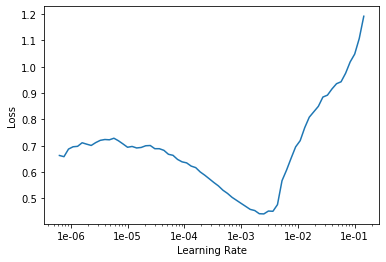

In [23]:
learn.recorder.plot()

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.118427,1.016746,0.236364,00:05
1,0.106087,1.010571,0.218182,00:05
2,0.081958,0.993980,0.236364,00:05
3,0.073683,0.984155,0.236364,00:05
4,0.066097,0.985662,0.236364,00:05
5,0.058248,0.956967,0.236364,00:05
6,0.065371,0.945437,0.236364,00:05
7,0.058208,0.945462,0.236364,00:05
8,0.055490,0.936496,0.236364,00:05
9,0.050302,0.962579,0.236364,00:05


In [0]:
learn.save('stage2')

In [0]:
learn.load('stage2');


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

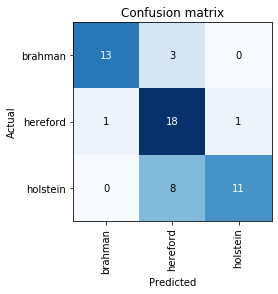

In [43]:
interp.plot_confusion_matrix()

In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

In [0]:
learn_cln.load('stage2');

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

## Putting your model in production

In [0]:
learn.export()

In [0]:
defaults.device = torch.device('cpu')

In [0]:
learn = load_learner('data/cattle/export.pkl')

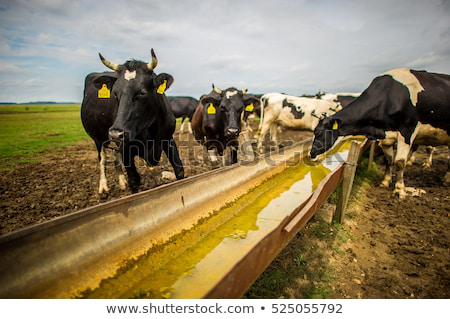

In [36]:
img = open_image(path/'holstein'/'00000021.jpg')
img

In [37]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category holstein

In [0]:
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })

# (This example is for the Starlette web app toolkit.)